In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import textwrap

In [3]:
# Load data
global_metadata = pd.read_csv('../../src/nlp/topic_modeling/topic_data.csv')
community_topic_counts = pd.read_csv('../../src/nlp/topic_modeling/community_topic_counts.csv')
hub_topic_counts = pd.read_csv('../../src/nlp/topic_modeling/hub_topic_counts.csv')
bridge_topic_counts = pd.read_csv('../../src/nlp/topic_modeling/bridge_topic_counts.csv')
top_n_topics = pd.read_csv('../../src/nlp/topic_modeling/top_n_topics.csv')
roles = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')

communities_info = roles[['community_id', 'community_type']].drop_duplicates()


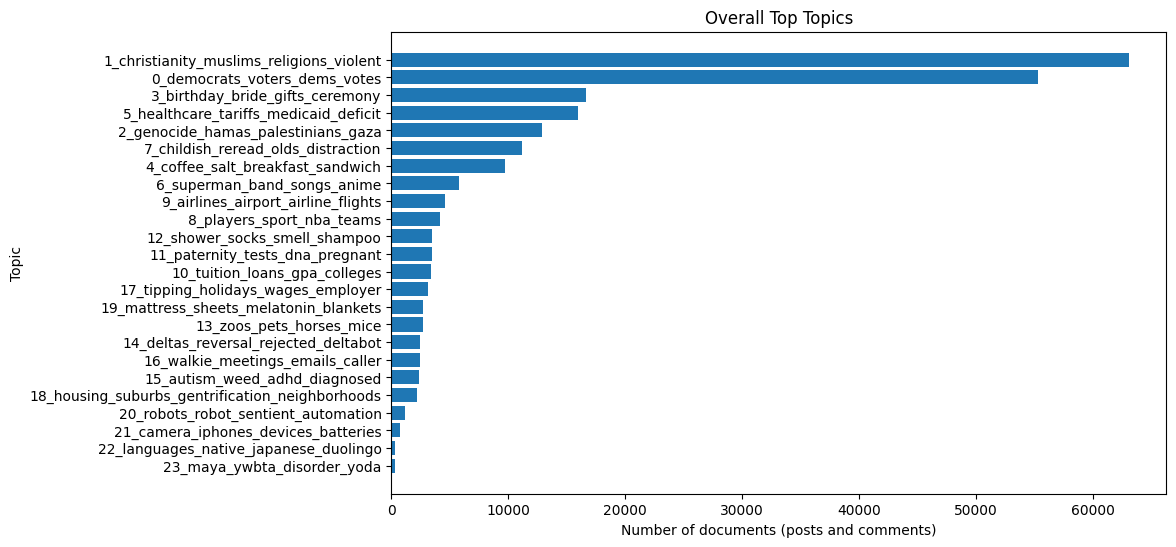

In [4]:
# Top global topics
topic_counts = global_metadata['topic'].value_counts().reset_index()
topic_counts.columns = ['topic', 'count']

plt.figure(figsize=(10,6))
plt.barh(topic_counts['topic'], topic_counts['count'])
plt.ylabel("Topic")
plt.xlabel("Number of documents (posts and comments)")
plt.title("Overall Top Topics")
plt.gca().invert_yaxis()
plt.show()

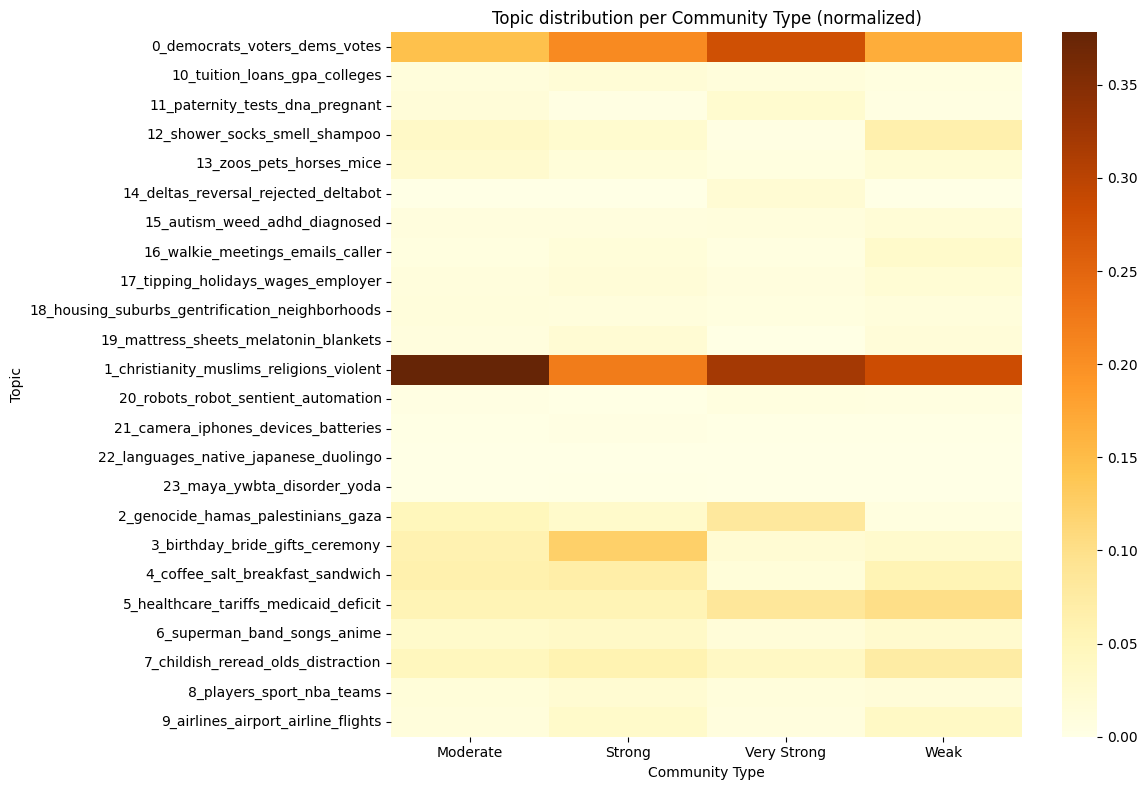

In [5]:
# Topic distribuition per community_type
community_topic_counts_with_type = community_topic_counts.merge(
    communities_info,
    on='community_id',
    how='left'
)

# Normalized percentage for topic category
topic_freq_by_type = community_topic_counts_with_type.groupby(
['community_type', 'topic']
)['count'].sum().reset_index()

total_by_type = topic_freq_by_type.groupby('community_type')['count'].transform('sum')
topic_freq_by_type['percent'] = topic_freq_by_type['count'] / total_by_type

pivot_heatmap = topic_freq_by_type.pivot(
index='topic', columns='community_type', values='percent'
).fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_heatmap, cmap="YlOrBr")
plt.title("Topic distribution per Community Type (normalized)")
plt.ylabel("Topic")
plt.xlabel("Community Type")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1618/4222331871.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=topic_diversity, x='community_type', y='topic_entropy', palette="Spectral")


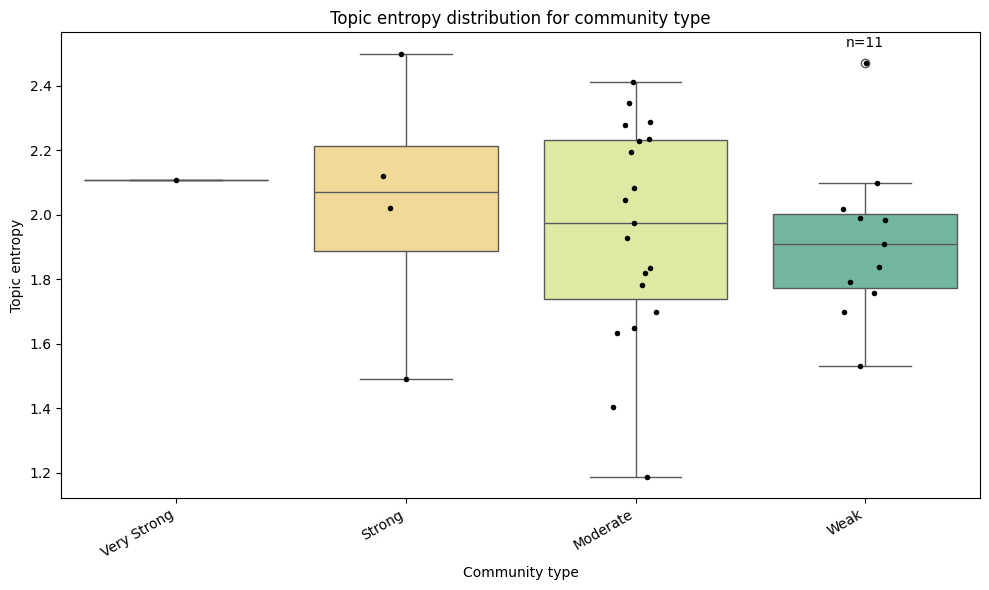

In [6]:
# Topic diversity  - entropy
topic_diversity = community_topic_counts_with_type.groupby('community_id').agg({
    'count': lambda x: entropy(x/x.sum()),
    'community_type': 'first'
}).reset_index().rename(columns={'count': 'topic_entropy'})


# Regulating plot type based on community nuber for each community category
plt.figure(figsize=(10, 6))
sns.boxplot(data=topic_diversity, x='community_type', y='topic_entropy', palette="Spectral")
sns.stripplot(data=topic_diversity, x='community_type', y='topic_entropy', color="black", size=4, jitter=True)

counts = topic_diversity.groupby('community_type')['community_id'].nunique()
for i, ct in enumerate(topic_diversity['community_type'].unique()):
    n = counts.get(ct, 0)
plt.text(i, topic_diversity['topic_entropy'].max() + 0.02, f"n={n}", ha='center')


plt.title("Topic entropy distribution for community type")
plt.xlabel("Community type")
plt.ylabel("Topic entropy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

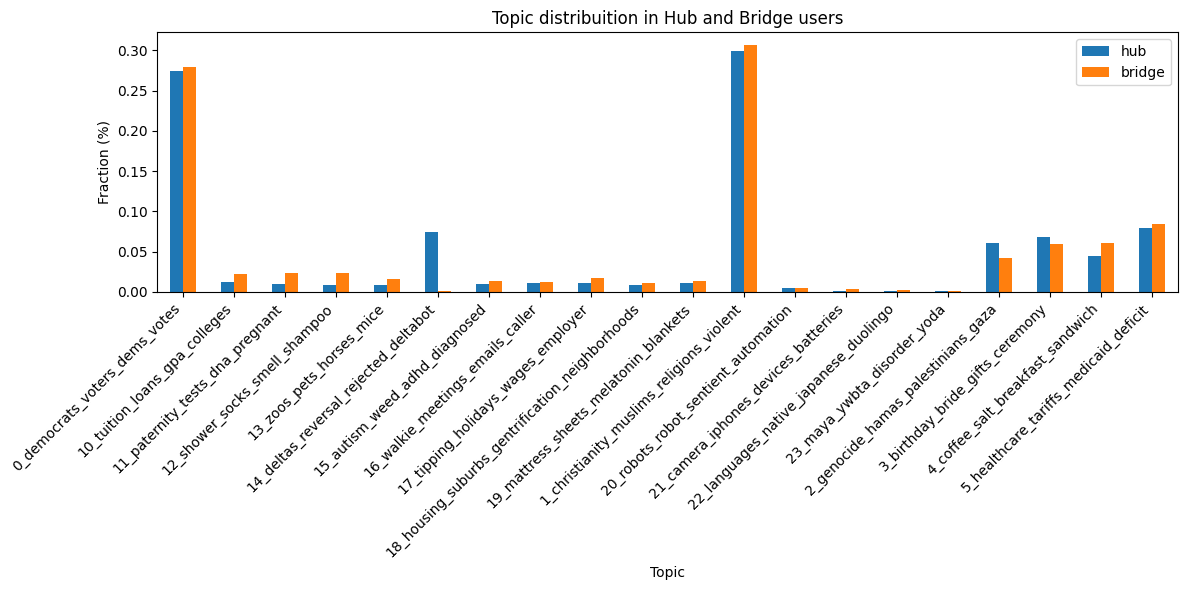

In [7]:
# Topic distribuition for Hub and Bridge users

hub_dist = hub_topic_counts.groupby('topic')['count'].sum().head(20)
hub_dist = hub_dist / hub_dist.sum()

bridge_dist = bridge_topic_counts.groupby('topic')['count'].sum().head(20)
bridge_dist = bridge_dist / bridge_dist.sum()

hub_bridge_df = pd.DataFrame({
'hub': hub_dist,
'bridge': bridge_dist
}).fillna(0)

hub_bridge_df.plot(kind='bar', figsize=(12,6))
plt.title("Topic distribuition in Hub and Bridge users")
plt.ylabel("Fraction (%)")
plt.xlabel("Topic")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

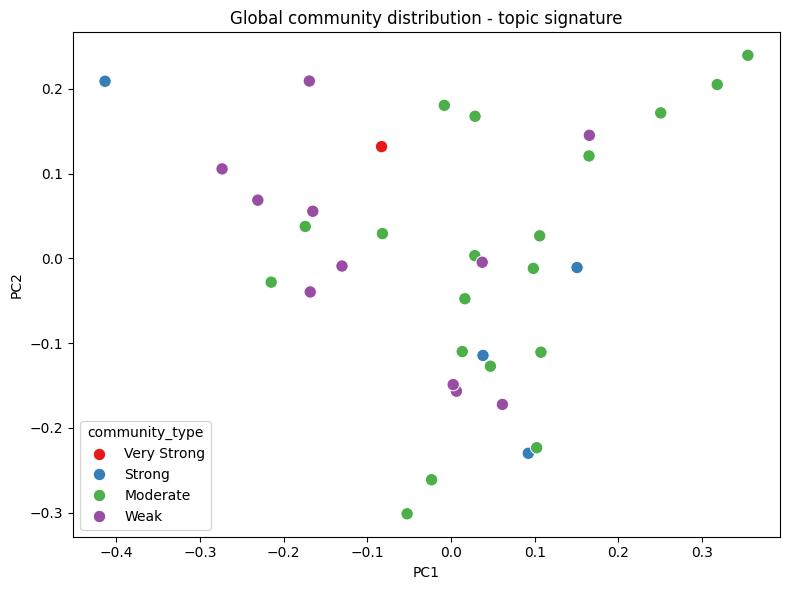

In [8]:
# Semantic distance between communities (Jensen-Shannon)
all_comms_df = community_topic_counts_with_type.pivot(index='community_id', columns='topic', values='count').fillna(0)
all_comms_normalized = normalize(all_comms_df, norm='l1')
community_ids = all_comms_df.index

# Pairwise Jensen-Shannon divergence
js_matrix = np.zeros((all_comms_normalized.shape[0], all_comms_normalized.shape[0]))
for i in range(all_comms_normalized.shape[0]):
    for j in range(all_comms_normalized.shape[0]):
        js_matrix[i,j] = jensenshannon(all_comms_normalized[i], all_comms_normalized[j])

# PCA embedding
pca = PCA(n_components=2)
coords = pca.fit_transform(all_comms_normalized)

coords_df = pd.DataFrame(coords, columns=['PC1', 'PC2'])
coords_df['community_id'] = community_ids  # Usa gli indici salvati

coords_df = coords_df.merge(communities_info, on='community_id', how='left')

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords_df['PC1'], y=coords_df['PC2'], hue=coords_df['community_type'], palette="Set1", s=80)
plt.title("Global community distribution - topic signature")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [20]:
sentiments = pd.read_csv('../../src/nlp/sentiment/sentiment_scores.csv')
sentiment_infos = sentiments.merge(roles, left_on='author', right_on='id', how='left')

sentiment_infos.head()

,author,id_x,model,neg_percentage,neu_percentage,pos_percentage,predicted_sentiment,id_y,degree,internal_degree,community_id,community_type,external_degree,pct_internal,pct_external,z_internal,betweenness,is_hub,is_bridge
0,Raichu4u,1mv3z5n,bertweet,0.564768,0.427656,0.007576,negative,Raichu4u,161,150,3,Strong,11,0.931677,0.068323,4.058989,690.125449,True,False
1,KingGhidorah1225,1musrfu,bertweet,0.228948,0.760878,0.010174,neutral,KingGhidorah1225,12,11,3,Strong,1,0.916667,0.083333,-0.391314,1585.497055,False,False
2,Potato_Cat93,1mujuir,bertweet,0.018053,0.972846,0.009100,neutral,Potato_Cat93,32,31,3,Strong,1,0.968750,0.031250,0.249018,1075.164585,False,False
3,Rong_Liu,1mumwdb,bertweet,0.002273,0.242203,0.755524,positive,Rong_Liu,15,15,3,Strong,0,1.000000,0.000000,-0.263247,1596.578320,False,False
4,Candle-Jolly,1mun37m,bertweet,0.031244,0.945634,0.023122,neutral,Candle-Jolly,68,67,3,Strong,1,0.985294,0.014706,1.401614,506.540427,False,False


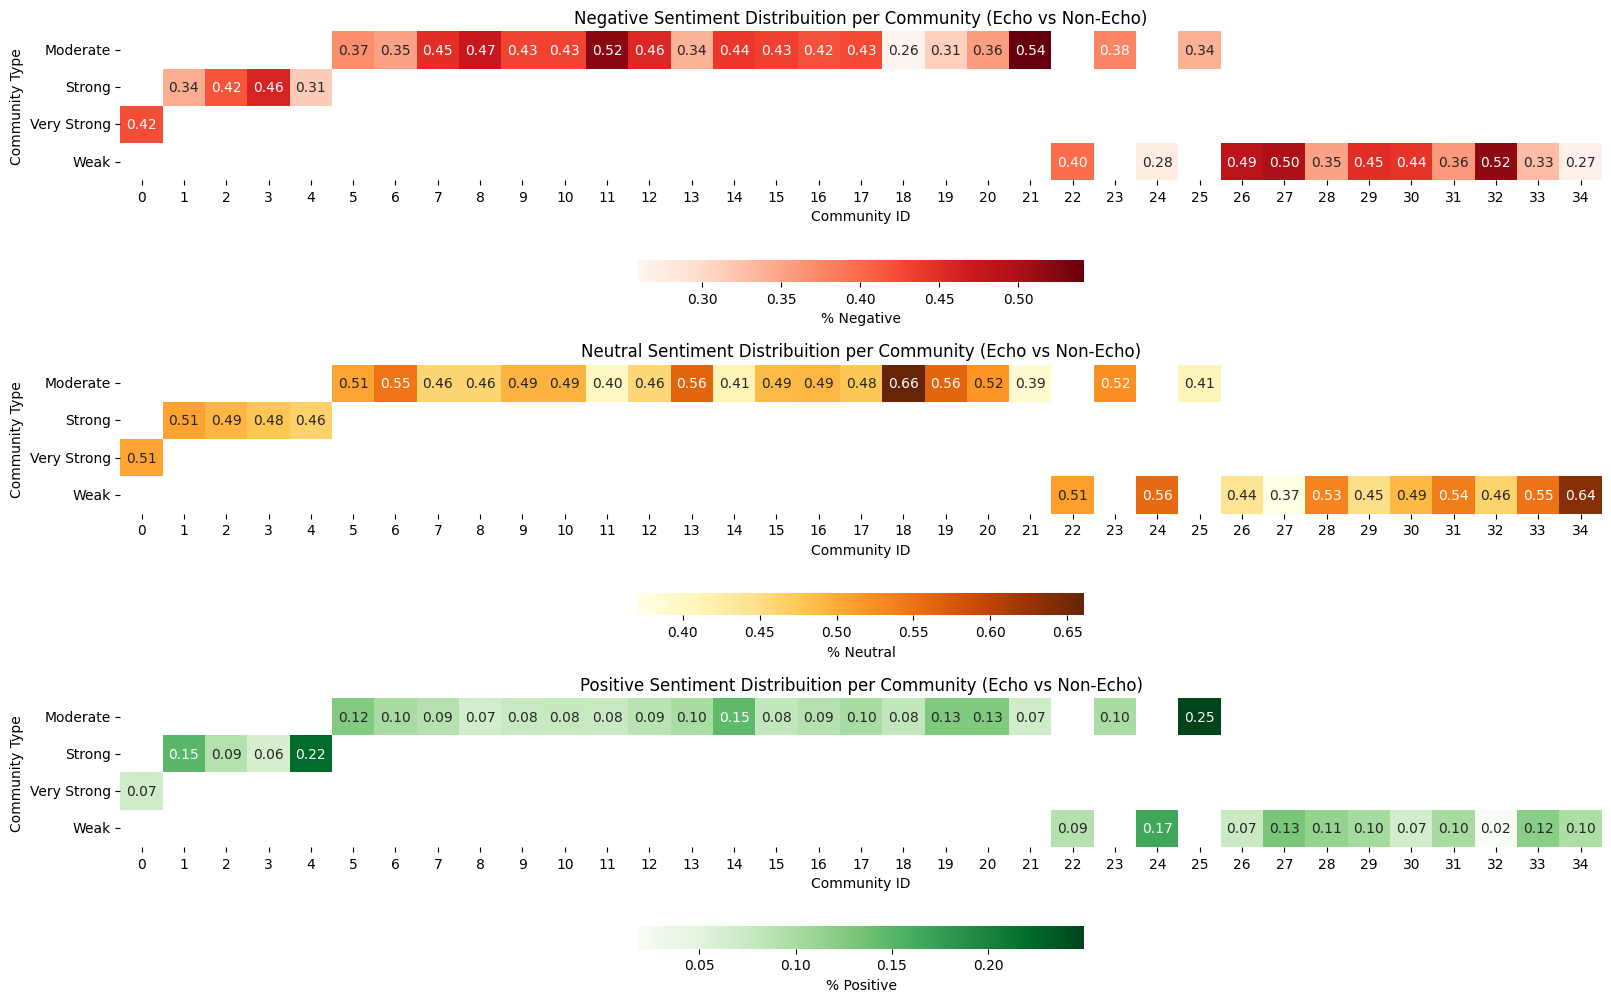

In [23]:
sentiment_stats = sentiment_infos.groupby(['community_id', 'community_type']).agg(
    Negative=('neg_percentage', 'mean'),
    Neutral=('neu_percentage', 'mean'),
    Positive=('pos_percentage', 'mean')
).reset_index()

# Step 2: Normalizzazione interna (ogni community = 100%)
sentiment_stats[['Negative', 'Neutral', 'Positive']] = sentiment_stats[['Negative', 'Neutral', 'Positive']].div(
    sentiment_stats[['Negative', 'Neutral', 'Positive']].sum(axis=1), axis=0
)

# Lista sentimenti e colormap dedicate
sentiments = {
    'Negative': 'Reds',
    'Neutral': 'YlOrBr',
    'Positive': 'Greens'
}

fig, axes = plt.subplots(3, 1, figsize=(16, 10), constrained_layout=True)

for i, (sentiment, cmap) in enumerate(sentiments.items()):
    heatmap_data = sentiment_stats.pivot(
        index='community_type', 
        columns='community_id', 
        values=sentiment
    )
    
    # Heatmap
    sns.heatmap(
        heatmap_data, 
        cmap=cmap, 
        annot=True, 
        fmt=".2f", 
        ax=axes[i],
        cbar_kws={'orientation': 'horizontal', 'shrink': 0.6, 'pad': 0.2, 'label': f"% {sentiment}"}
    )
    
    # Titolo
    axes[i].set_title(f"{sentiment} Sentiment Distribuition per Community (Echo vs Non-Echo)", fontsize=12)
    axes[i].set_xlabel("Community ID")
    axes[i].set_ylabel("Community Type")

plt.show()

